<a href="https://colab.research.google.com/github/ma-zeller/IANNwTF/blob/main/IANNwTF_HW_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds   
from tensorflow.keras import layers
from tensorflow.keras.utils import Progbar
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np
import math
import datetime
import os
import glob
import imageio
import PIL
import time

from IPython import display

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


*   make optimizer a hyperparameter
*   disable batch norm while generating images
*   rethink upscaling



**1. Create Dataset**


In [ ]:
import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [ ]:
# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images to train on')

141545 images to train on


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(images[:30000])
test_ds = tf.data.Dataset.from_tensor_slices(images[30000:40000])

In [ ]:
# # test with MNIST
# ( train_ds , test_ds ), ds_info = tfds.load("mnist", split =[ "train", "test"], as_supervised =True , with_info = True)
# train_ds = train_ds.map(lambda img, label: (img))
# test_ds = test_ds.map(lambda img, label: (img))

In [ ]:
# Define hyperparamaters
epochs = 20
batch_size = 32
droprate = 0.25
gen_opt = tf.keras.optimizers.Adam(0.01)
disc_opt = tf.keras.optimizers.Adam(0.01)
ls_size = 100
assert np.sqrt(ls_size)%2==0 or (np.sqrt(ls_size)+1)%2==0

In [ ]:
def ds_preprocess(ds):

    # cast
    ds = ds.map(lambda img: (tf.cast(img,tf.float32)))

    # reshape
    ds = ds.map(lambda img: (tf.reshape(img,(28,28,1))))
    
    # normalize images between range (-1,1)
    ds = ds.map(lambda img: ((img/128)-1))

    # shuffle
    ds = ds.shuffle(10000)

    # batch
    ds = ds.batch(batch_size)

    # prefetch
    ds = ds.prefetch(batch_size)
    
    return ds

In [ ]:
# apply perprocessing
train_dataset = train_ds.apply(ds_preprocess)
test_dataset = test_ds.apply(ds_preprocess)

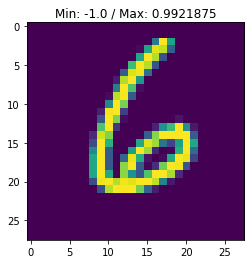

In [ ]:
# show examples

for img in train_dataset:
  candle = img[0].numpy().reshape(28,28)
  plt.imshow(candle)
  plt.title(f"Min: {candle.min()} / Max: {candle.max()}")
  break

In [ ]:
class DiscriminatorCNN(tf.keras.Model):
    def __init__(self):
        super(DiscriminatorCNN,self).__init__()

        # Downsample
        self.s_b_1 = tf.keras.layers.Conv2D(filters=1,kernel_size=3,padding="valid",strides=2,activation=tf.keras.layers.LeakyReLU(alpha=0.01))

        # Dropout
        self.do_1 = tf.keras.layers.Dropout(droprate)

        # Downsample
        self.s_b_2 = tf.keras.layers.Conv2D(filters=1,kernel_size=3,padding="valid",strides=2,activation=tf.keras.layers.LeakyReLU(alpha=0.01))

        # Dropout
        self.do_2 = tf.keras.layers.Dropout(droprate)

        # Fully connected 
        self.f1 = tf.keras.layers.Flatten()
        self.out = tf.keras.layers.Dense(1)#,activation="sigmoid")

        # Loss function (from logits correct?)
        self.loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    @tf.function
    def call(self,x):

        # print(f"Discriminator Input: {x.shape}")

        x = self.s_b_1(x)
        x = self.do_1(x)
        # print(f"Discriminator DS1: {x.shape}")

        x = self.s_b_2(x)
        x = self.do_2(x)
        # print(f"Discriminator DS3: {x.shape}")

        x = self.f1(x)
        # print(f"Discriminator FC1: {x.shape}")

        x = self.out(x)
        # print(f"Discriminator OUT: {x.shape}")

        return x  
    
    def discriminator_loss(self,real_output, fake_output):
        real_loss = self.loss(tf.ones_like(real_output), real_output)
        fake_loss = self.loss(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        
        return total_loss

class GeneratorCNN(tf.keras.Model):
    def __init__(self):
        super(GeneratorCNN,self).__init__()

        # Reshape
        self.rs_1 = tf.keras.layers.Reshape((int(np.sqrt(ls_size)),int(np.sqrt(ls_size)),1))

        # Upsampling Layers (still hardcoded depening on latent space size, also probably not optimal)
        self.us_1 = tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=5,padding="valid",strides=2,activation=tf.keras.layers.LeakyReLU(alpha=0.01),output_padding=1)
        self.us_2 = tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=5,padding="valid",strides=1,activation=tf.keras.layers.LeakyReLU(alpha=0.01),output_padding=0)

        # BN Layers
        self.bn_1 = tf.keras.layers.BatchNormalization()
        self.bn_2 = tf.keras.layers.BatchNormalization()

        # Out
        self.out = tf.keras.layers.Conv2D(filters=1,kernel_size=1,activation="tanh")

        # Loss function (from logits correct?)
        self.loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    @tf.function
    def call(self,x,training=None):

        x = self.rs_1(x)
        # print(f"Generator Reshape: {x.shape}")

        x = self.us_1(x)
        if training == None:
          x = self.bn_1(x) 
        # print(f"Generator US1: {x.shape}")
        
        x = self.us_2(x)
        if training == None:
          x = self.bn_2(x)
        # print(f"Generator US2: {x.shape}")
        
        x = self.out(x)
        # print(f"Generator out: {x.shape}")

        return x

    def generator_loss(self,fake_output):
        return self.loss(tf.ones_like(fake_output), fake_output)
        

class GAN(tf.keras.Model):
    def __init__(self):
        super(GAN,self).__init__()

        self.generator = GeneratorCNN()
        self.discriminator = DiscriminatorCNN()

        self.generator_optimizer = gen_opt
        self.discriminator_optimizer = disc_opt

    @tf.function
    def call(self,images):

      # generate ls_vector from noise [bs,ls_size]
      noise = tf.random.normal((batch_size,ls_size))

      # feed noise to generator
      generator_out = self.generator(noise)

      # feed fake images to discriminator
      discriminator_fake_img = self.discriminator(generator_out)

      # feed real images to discriminator
      discriminator_real_img = self.discriminator(images)

      return discriminator_real_img, discriminator_fake_img

    @tf.function
    def train_step(self,images):

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

          # get required outputs from gen and disc
          disc_real, disc_fake  = model(images)

          # get respective losses
          gen_loss = self.generator.generator_loss(disc_fake)
          disc_loss = self.discriminator.discriminator_loss(disc_real, disc_fake)

        # update
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return gen_loss, disc_loss

In [ ]:
# # instatiate for tests
# gen = GeneratorCNN()
# disc = DiscriminatorCNN()

In [ ]:
# # test generator
# gen_img = gen(tf.random.normal((batch_size,ls_size)))
# plt.imshow(gen_img[1].numpy().reshape(28,28))

In [ ]:
# # test discriminator
# out_disc = disc(gen_img)
# print(out_disc.shape)

In [ ]:
# instantiate GAN model
model = GAN()
model.build((batch_size,28,28,1))
model.summary()

Model: "gan_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_cnn_3 (GeneratorC  multiple                 54        
 NN)                                                             
                                                                 
 discriminator_cnn_3 (Discri  multiple                 57        
 minatorCNN)                                                     
                                                                 
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Logging
config_name= "IANNwTF_HW9"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

gen_log_path = f"logs/{config_name}/{current_time}/gen"
disc_log_path = f"logs/{config_name}/{current_time}/disc"

# log writers for metrics
gen_summary_writer = tf.summary.create_file_writer(gen_log_path)
disc_summary_writer = tf.summary.create_file_writer(disc_log_path)

# metrics
loss_metric_gen = tf.keras.metrics.Mean(name="loss_gen")
loss_metric_disc = tf.keras.metrics.Mean(name="loss_disc")

60000/60000 [==============================] - 15s 243us/step
Gen loss at epoch 1: 2.1976242065429688
Disc loss at epoch 1: 0.705208957195282



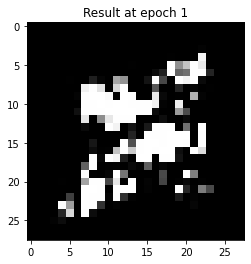

60000/60000 [==============================] - 13s 224us/step
Gen loss at epoch 2: 1.937947154045105
Disc loss at epoch 2: 0.7854890823364258



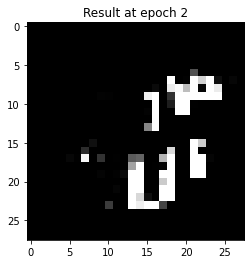

60000/60000 [==============================] - 13s 223us/step
Gen loss at epoch 3: 1.8741204738616943
Disc loss at epoch 3: 0.8341414332389832



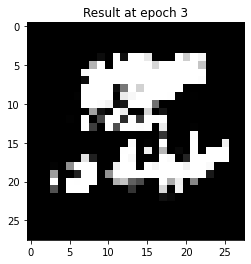

60000/60000 [==============================] - 15s 249us/step
Gen loss at epoch 4: 1.9242223501205444
Disc loss at epoch 4: 0.8473604917526245



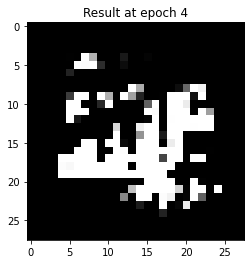

60000/60000 [==============================] - 13s 224us/step
Gen loss at epoch 5: 1.924424648284912
Disc loss at epoch 5: 0.8383130431175232



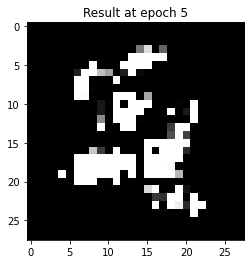

60000/60000 [==============================] - 14s 236us/step
Gen loss at epoch 6: 1.9604547023773193
Disc loss at epoch 6: 0.8269417881965637



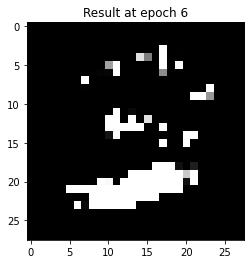

60000/60000 [==============================] - 14s 225us/step
Gen loss at epoch 7: 1.9771103858947754
Disc loss at epoch 7: 0.8190038800239563



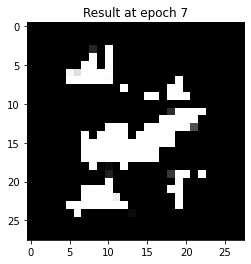

60000/60000 [==============================] - 14s 232us/step
Gen loss at epoch 8: 1.9503577947616577
Disc loss at epoch 8: 0.834993302822113



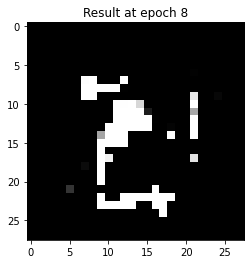

60000/60000 [==============================] - 13s 224us/step
Gen loss at epoch 9: 1.975988745689392
Disc loss at epoch 9: 0.8269720673561096



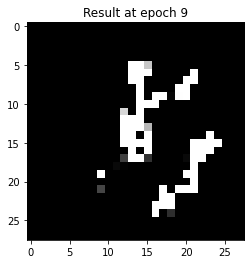

60000/60000 [==============================] - 14s 226us/step
Gen loss at epoch 10: 2.0136051177978516
Disc loss at epoch 10: 0.7896164059638977



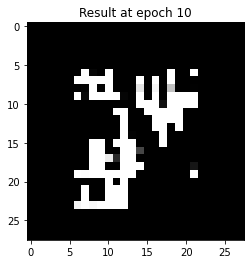

60000/60000 [==============================] - 14s 226us/step
Gen loss at epoch 11: 2.0170464515686035
Disc loss at epoch 11: 0.822536826133728



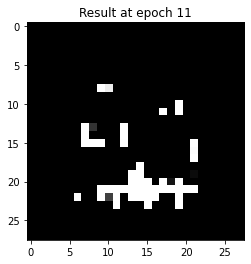

60000/60000 [==============================] - 13s 223us/step
Gen loss at epoch 12: 2.0275087356567383
Disc loss at epoch 12: 0.8072183728218079



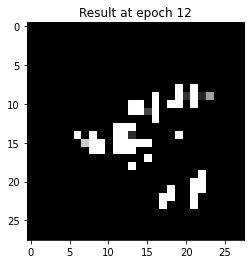

60000/60000 [==============================] - 13s 224us/step
Gen loss at epoch 13: 1.962916374206543
Disc loss at epoch 13: 0.834362804889679



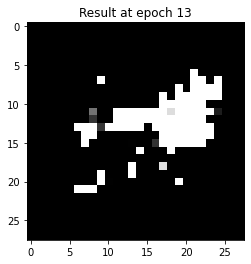

60000/60000 [==============================] - 13s 225us/step
Gen loss at epoch 14: 1.952149510383606
Disc loss at epoch 14: 0.8342067003250122



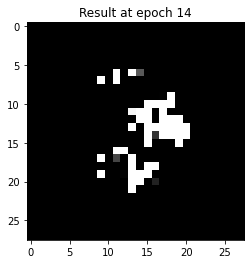

60000/60000 [==============================] - 13s 225us/step
Gen loss at epoch 15: 2.1311707496643066
Disc loss at epoch 15: 0.752926230430603



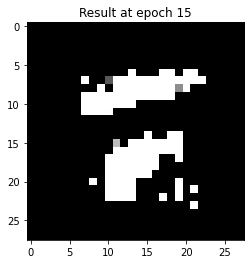

60000/60000 [==============================] - 14s 225us/step
Gen loss at epoch 16: 2.0377323627471924
Disc loss at epoch 16: 0.7928034067153931



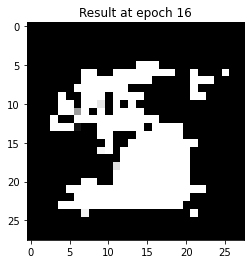

60000/60000 [==============================] - 13s 224us/step
Gen loss at epoch 17: 2.0482256412506104
Disc loss at epoch 17: 0.8304378986358643



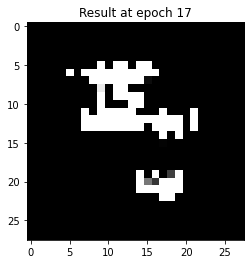

60000/60000 [==============================] - 14s 226us/step
Gen loss at epoch 18: 2.200329542160034
Disc loss at epoch 18: 0.767436146736145



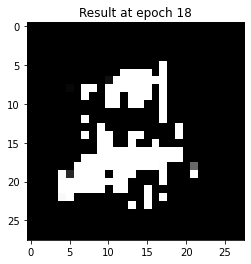

60000/60000 [==============================] - 14s 226us/step
Gen loss at epoch 19: 2.1700055599212646
Disc loss at epoch 19: 0.7500342726707458



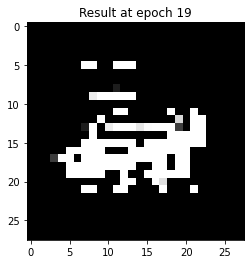

60000/60000 [==============================] - 14s 227us/step
Gen loss at epoch 20: 2.1141223907470703
Disc loss at epoch 20: 0.7860540151596069



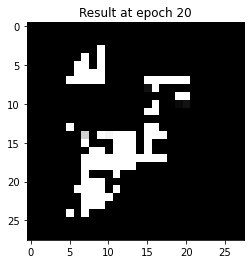

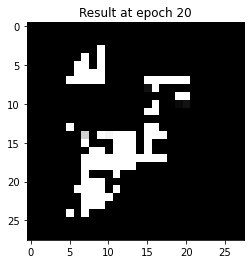

In [ ]:
# main loop
for epoch in range(epochs):

    pb_i = Progbar(len(train_dataset)*batch_size)

    # train loop
    for input in train_dataset:
        
        # train
        gen_loss, disc_loss = model.train_step(input)

        # save loss
        loss_metric_gen.update_state(values=gen_loss)
        loss_metric_disc.update_state(values=disc_loss)
        
        # update progbar
        pb_i.add(batch_size)

    print(f"Gen loss at epoch {epoch+1}: {loss_metric_gen.result()}")
    print(f"Disc loss at epoch {epoch+1}: {loss_metric_disc.result()}\n")

    # logging metrics
    with gen_summary_writer.as_default():
        tf.summary.scalar(f"{loss_metric_gen.name}", loss_metric_gen.result(), step=epoch)

    with disc_summary_writer.as_default():
        tf.summary.scalar(f"{loss_metric_disc.name}", loss_metric_disc.result(), step=epoch)

    # show intermediate results
    image = model.generator(tf.random.normal((batch_size,ls_size)),training=False)
    plt.imshow(image[0].numpy().reshape(28,28)*128+1,cmap="gray")
    plt.title(f"Result at epoch {epoch+1}")
    display.display(plt.gcf())

    # reset
    loss_metric_gen.reset_states()
    loss_metric_disc.reset_states()

In [ ]:
%tensorboard --logdir logs/